### Машинное обучение "без учителя". Задача кластеризации. 

В практических примерах ниже показано:   

* как пользоваться инструментами визуального анализа для предварительной интерпретации кластеров 
* как проводить кластерный анализ 
* как строить прогноз принадлежности к кластерам новых наблюдений
* как оценивать точность кластеризации

*Модели*: иерархический и неиерархический кластерный анализ

*Данные*: load_iris

### Импорт пакетов

In [1]:
import numpy as np
import pandas as pd
# процедура стандартизации
from sklearn.preprocessing import StandardScaler
# алгоритм k-средних
from sklearn.cluster import KMeans
# алгоритм k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
# дендрограмма
from scipy.cluster.hierarchy import dendrogram, linkage
# дендрограмма, расчет матрицы расстояний
from scipy.spatial.distance import pdist
# метрики
from sklearn import metrics 
# кластерные силуэты
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from matplotlib import pyplot as plt
import seaborn
seaborn.set_theme()
from sklearn.datasets import load_iris 
data = load_iris()
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

Данные в примере:
* **sepal length (cm)** - длина чашелистика (см)
* **sepal width (cm)** - ширина чашелистика (см)
* **petal length (cm)** - длина лепестка (см)
* **petal width (cm)** - ширина лепестка (см)

Задача состоит в разделении ирисов на группы в зависимости от  показателей(sepal length (cm) petal length (cm))

In [20]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [21]:
df = df[['sepal length (cm)', 'petal width (cm)']]
df.columns = ["sepal_length", "petal_width"]
df

,sepal_length,petal_width
0,5.1,0.2
1,4.9,0.2
2,4.7,0.2
3,4.6,0.2
4,5.0,0.2
...,...,...
145,6.7,2.3
146,6.3,1.9
147,6.5,2.0
148,6.2,2.3


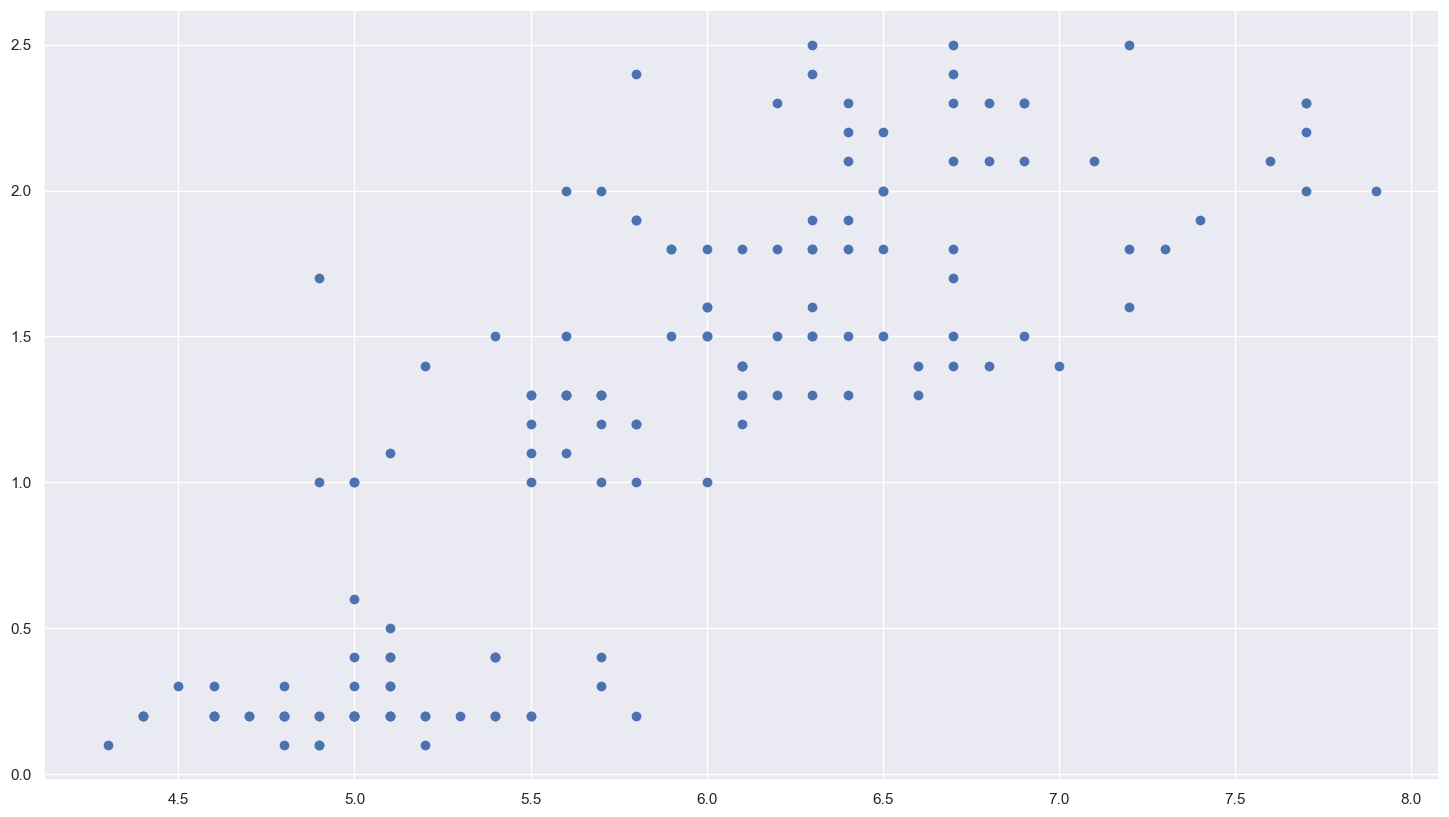

In [22]:
plt.figure(figsize=(18, 10))
plt.scatter(df.sepal_length, df.petal_width)

Можно предположить, что лучше всего будет сгруппировать данные на 4 группы. Тем не менее, рассмотрим метод для определения наилучшего количества кластеров.

#### Определение оптимального количества кластеров для метода локтя

Одна из основных трудностей в обучении без учителя состоит в том, что мы не знаем точного ответа. В нашем наборе данных нет 
установленных данных о метках классов, поэтому для количественного определения качества кластеризации нам нужно использовать внутренние метрики - такие как внутрикластерная **SSE** (искажение или инерция):
$$SSE = \sum\limits_{i=1}^n\sum\limits_{j=1}^kw_{ij}(x_i - m_i)^2$$

Здесь $w_{ij}$ = 1, если наблюдение относится к кластеру $j$ и 0 в противоположном случае, а $m_i$ - центроид кластера.

Основываясь на внутрикластерной SSE, мы можем применить графический инструмент, так называемый метод локтя, для оценки оптимального числа k кластеров для поставленной задачи. Интуитивно мы можем сказать, что если k увеличивается, то искажение уменьшается. Это вызвано тем, что образцы будут ближе к центроидам, которым они назначены. В основе метода локтя лежит идея, которая состоит в том, чтобы идентифицировать значение k в точке, где искажение начинает увеличиваться быстрее всего, что станет понятнее, если мы построим график искажения для разных значений k.

Text(0, 0.5, 'Искажение ')

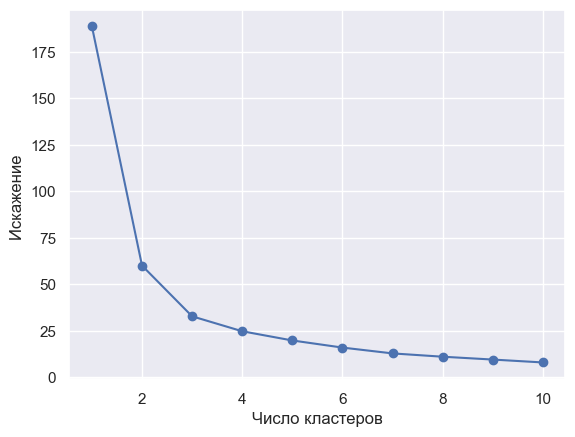

In [23]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на графике выше, локоть расположен в k = 3, что свидетельствует о том, что k = 3 является хорошим выбором для этого набора данных.

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


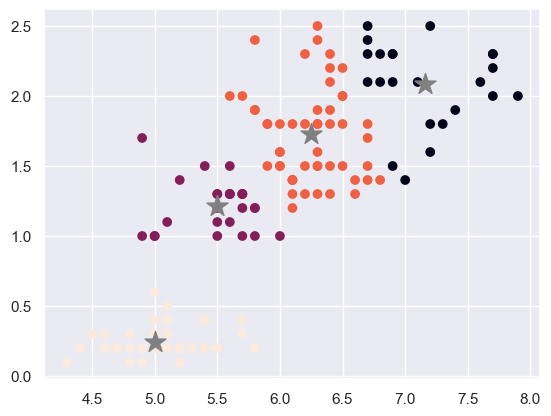

In [24]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df.values)
plt.scatter(df.sepal_length, df.petal_width, c=kmeans.labels_)
# нарисуем центроиды
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=250, marker= '*', c = 'grey', label = 'центроиды')

Сделаем построение и для 3-ёх групп:

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


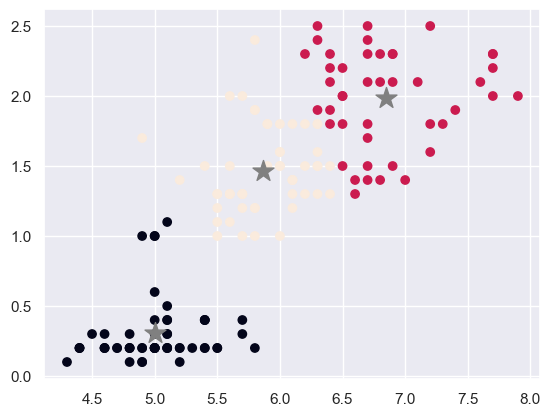

In [25]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
plt.scatter(df.sepal_length, df.petal_width, c=kmeans.labels_)
# нарисуем центроиды
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=250, marker= '*', c = 'grey', label = 'центроиды')

Теперь видим, что каждая группа точек покрашена в цвет соответствующего кластера, а центроиды расположены внутри множества точек. Тем не менее, попробуем оценить качество кластеризации в обоих вариантах.

#### Количественная оценка качества кластеризации


Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.

Выделяют *внешние* и *внутренние* метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.

Еще одна внутренняя метрика для оценки качества кластеризации (наряду с **SSE**) представлена силуэтным анализом
Силуэтный анализ может использоваться в качестве графического инструмента для построения графика меры плотности группировки образцов в кластерах. 
Чтобы вычислить силуэтный коэффициент наблюдения в нашем наборе данных, можно применить следующие три шага. 
1. Вычислить *внутриклассовую связность* $a_i$ как среднее расстояние между наблюдением и другими точками кластера
2. Вычислить *межкластерное разделение* $b_i$ от следующего ближайшего кластера как среднее расстояние между наблюдением $х_i$ и всеми наблюдениями в ближайшем кластере
3. Вычислить *силуэт* $s_i$:
$$s_i = (b_i - a_i)/\max(b_i,a_i).$$

$s_i$ принимает значения в диапазоне $[-1, 1]$. Идеальное совпадение - когда $s_i = 1.$

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Средний коэффициент силуэта --  0.5039558227584355


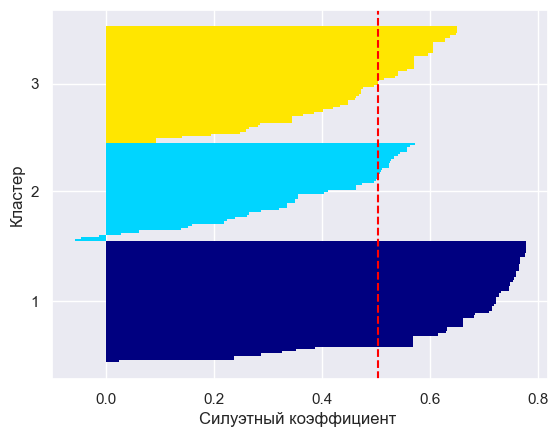

In [26]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

cluster_labels = np.unique(y_km) 
n_clusters = cluster_labels.shape[0] 
silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')

# изобразим график силуэтов
y_ax_lower , y_ax_upper = 0, 0 
yticks = [] 
for i, c in enumerate(cluster_labels): 
    c_silhouette_vals = silhouette_vals[y_km == c] 
    c_silhouette_vals.sort() 
    y_ax_upper += len(c_silhouette_vals) 
    color = cm.jet(float(i) / n_clusters) 
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals , 
             height=1.0, 
             edgecolor='none', 
             color=color) 
    yticks.append((y_ax_lower + y_ax_upper) / 2) 
    y_ax_lower += len(c_silhouette_vals) 
silhouette_avg = np.mean(silhouette_vals) 
    
plt.axvline(silhouette_avg, color= "red", linestyle="--" ) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel ('Кластер') 
plt.xlabel('Силуэтный коэффициент ' ) 
plt.show() 

Средний коэффициент силуэта весьма близок к 0.5, что говорит о относительным качестве кластеризации.
Если силуэты зрительно значительно отличаются друг от друга по длине, то это является признаком *субоптимальной* кластеризации. Как правило, в этом случае центроиды кластеров стоят отдельно от множества точек кластера. 
Посчитаем средний коэффициент силуэта для кластеризации $k=4$. 

In [27]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.4634141452435154


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Его значение немного ниже, чем в предыдущем случае. Формально $k=3$ - более оптимальное разбиение.

#### Сравнение результатов на обучающей и тестовой выборке
Посмотрим, как прогнозировать новых наблюдений принадлежность к кластерам, построенным по обучающим данным. Сравним значения средних силуэтных коэффициентов.

В обучающей выборке - 80% исходных наблюдений.

In [28]:
DF = pd.DataFrame(data.data, columns=data.feature_names)
DF.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Добавляем к выборке дополнительный показатель.

In [29]:
DF = DF[['sepal length (cm)', 'petal width (cm)', 'sepal width (cm)']]
DF.columns = ["sepal_length", "petal_width", "sepal_width"]
DF

,sepal_length,petal_width,sepal_width
0,5.1,0.2,3.5
1,4.9,0.2,3.0
2,4.7,0.2,3.2
3,4.6,0.2,3.1
4,5.0,0.2,3.6
...,...,...,...
145,6.7,2.3,3.0
146,6.3,1.9,2.5
147,6.5,2.0,3.0
148,6.2,2.3,3.4


In [30]:
DF_train = DF.sample(frac=0.8)

# данные для прогнозов
DF_predict = DF.drop(DF_train.index)


Text(0, 0.5, 'Искажение ')

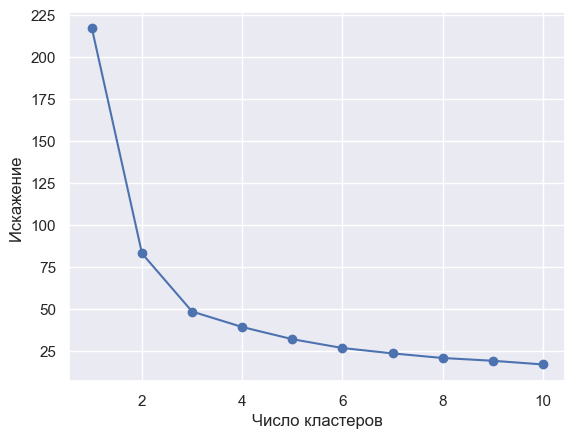

In [31]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(DF)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на графике выше, заметных изменений не обнаружилось.

Обучаем алгоритм и считаем средний силуэтный коэффициент.

In [32]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(DF_train.values)
y_km_train = kmeans.fit_predict(DF_train) 
silhouette_vals = silhouette_samples(DF_train, y_km_train, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.46394435413444274


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
y_km_predict = kmeans.fit_predict(DF_predict) 
silhouette_vals = silhouette_samples(DF_predict, y_km_predict, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

Средний коэффициент силуэта --  0.4921130197472057


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Применяем модель к новым данным. Значение среднего силуэтного коэффициента незначительно ухудшилось.

#### Статистический анализ получившихся кластеров

In [34]:
# снова работаем со всей выборкой
# добавляем метки кластеров в качестве нового столбца к фрейму
kmeans = KMeans(n_clusters=3,random_state=0).fit(DF.values)
DF["KM"] = kmeans.fit_predict(DF) 

C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


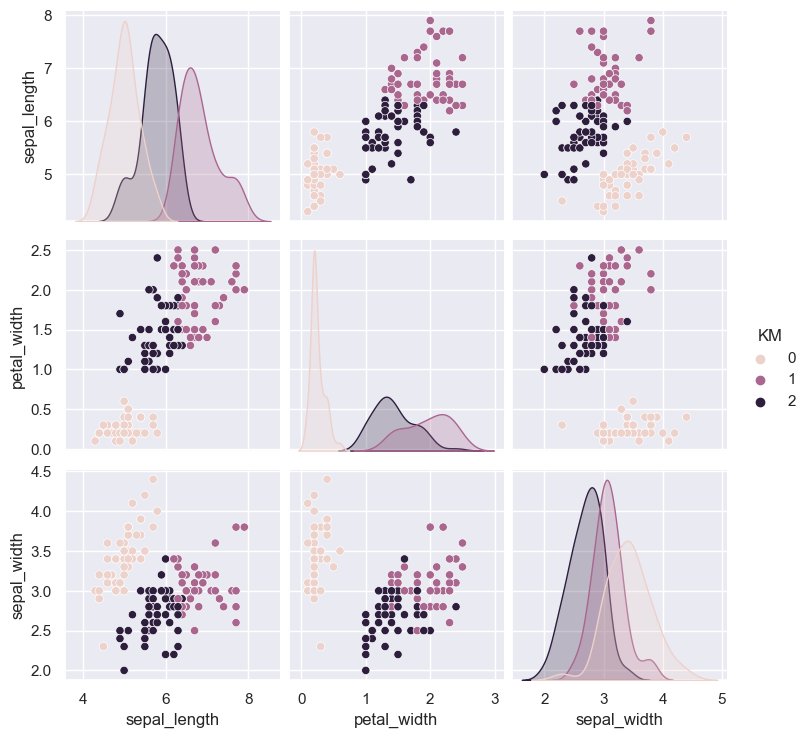

In [35]:
seaborn.pairplot(DF, hue='KM')
plt.show()

Визуально  кластеры  немного отличаются друг от друга. Судя по графикам плотности, по показателю **sepal_length** имеют различия, а по **petal_width** и **sepal_width** имеют некоторые сходства. По диаграммам разброса видно, что оба кластера образуют не совсем плотное множество точек, разбиение нестрогое.

In [41]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.49333333333333335


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Из оценки кластеризации следует, что алгоритм (при разбиении на 3 кластера) достиг средней точности в своей работе.

In [47]:
kmeans = KMeans(n_clusters=2, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

Accuracy: 0.6666666666666666


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Из оценки кластеризации следует, что алгоритм (при разбиении на 2 кластера) достиг средней точности в своей работе.